## Image reconstruction

Want to reproduce a [simple example](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(1, 380, 300, 3)


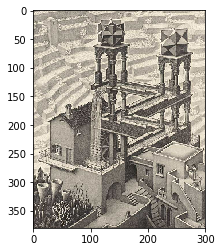

In [2]:
img = tf.image.decode_jpeg(tf.read_file('waterfall.jpg'))
img = tf.cast(img, tf.float32)/255
img = tf.expand_dims(img, 0)
# NOTE Works better with bigger images?
img = img[:, ::2, ::2, ...]
print(img.shape)
plt.imshow(img[0])

In [6]:
class Sampler():
    def __init__(self, shape, p):
        _, nx, ny, nz = shape
        N = nx * ny * nz
        k = round(N * p)
        samples = np.random.choice(N, k, replace=False)
        self.idx = tf.constant(samples, dtype=tf.int32, shape=[k])
    
    def __call__(self, x):
        return tf.gather(tf.reshape(x, [-1]), self.idx)

sampler = Sampler(img.numpy().shape, 0.25)

In [7]:
y = sampler(img)

In [8]:
def dLdx(var, target, beta=0.1):
    with tf.GradientTape() as tape:
        # the candidate var should match the measurements made
        recon = tf.losses.mean_squared_error(sampler(var), target)
        
        # project var to a sparse basis
        h = tf.fft2d(tf.cast(var, tf.complex64))
        # the l1 regularisation term
        reg = beta*tf.reduce_mean(tf.abs(h)) 
        loss = recon + reg 
        
        print('\rloss: {:.4f} recon: {:.4f} reg: {:.4f} '.format(loss, recon, reg), 
              end='', flush=True)

    return tape.gradient(loss, [var])

In [9]:
steps = 100

This is quite slow...
How does this algol scale with; size of image, many images, ...?


This is convex optimisation right!? Anything smarter we can do here?

loss: 4.0395 recon: 1.3739 reg: 2.6656 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 1.4566 recon: 0.3326 reg: 1.1240 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.6562 recon: 0.1114 reg: 0.5448 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.3628 recon: 0.0730 reg: 0.2898 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.2205 recon: 0.0533 reg: 0.1672 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.1201 recon: 0.0347 reg: 0.0855 

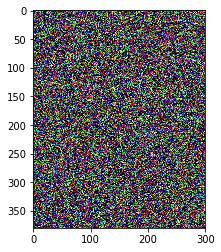

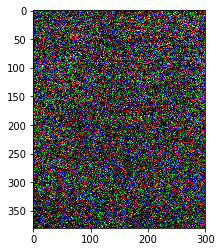

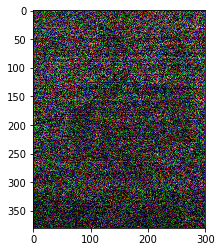

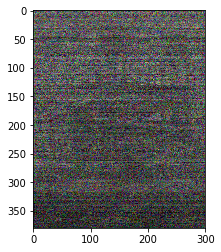

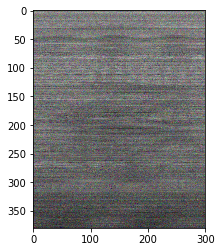

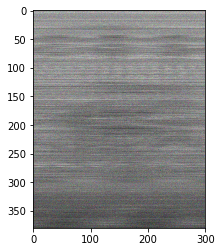

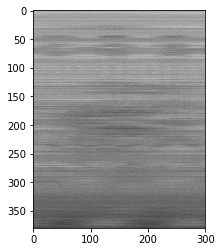

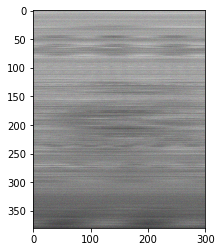

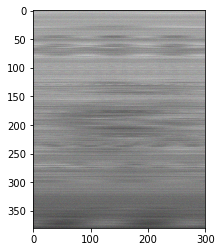

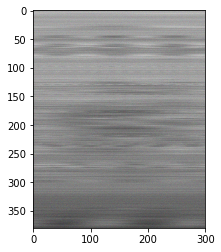

In [10]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=0.01)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
    if i % int(steps/10) == 0:
        plt.figure()
        plt.imshow(var[0])

loss: 1.4061 recon: 1.3795 reg: 0.0267 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.3196 recon: 0.3019 reg: 0.0177 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0772 recon: 0.0660 reg: 0.0111 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0297 recon: 0.0224 reg: 0.0073 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0139 recon: 0.0090 reg: 0.0049 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0068 recon: 0.0034 reg: 0.0034 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0040 recon: 0.0012 reg: 0.0027 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0029 recon: 0.0004 reg: 0.0025 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0025 recon: 0.0002 reg: 0.0024 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0024 recon: 0.0001 reg: 0.0023 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.0023 recon: 0.0001 reg: 0.0023 

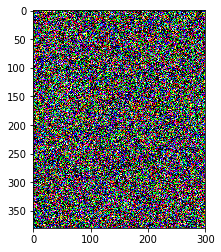

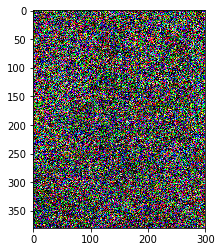

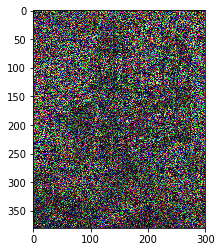

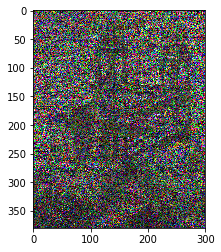

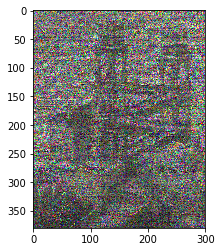

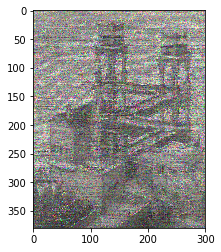

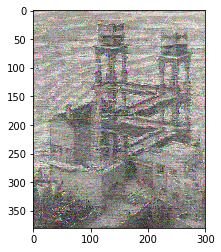

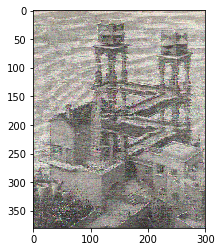

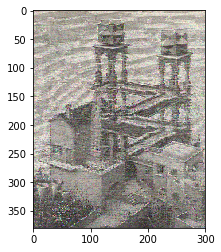

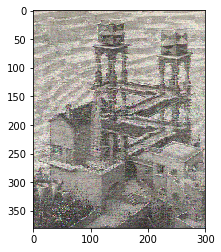

In [11]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=0.001)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
    if i % int(steps/10) == 0:
        plt.figure()
        plt.imshow(var[0])